<a href="https://colab.research.google.com/github/chillukamaripranaya143/Alzheimer_mini/blob/main/final(SE_RESNET%2BVGG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet

# Upload your Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json from your Kaggle account

# Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d ashrafulhossenakash/alzheimer-disease-dataset

# Unzip dataset
!unzip -q alzheimer-disease-dataset.zip -d /content/
!ls /content/Dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ashrafulhossenakash/alzheimer-disease-dataset
License(s): CC0-1.0
 90% 310M/346M [00:00<00:00, 889MB/s] 
100% 346M/346M [00:00<00:00, 733MB/s]
ls: cannot access '/content/Dataset': No such file or directory


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ======================
# 2. DATASET SETUP
# ======================

base_dir = "/content/Alzheimer_Dataset_V2"   # Change if needed
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Detected Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 23788 files belonging to 4 classes.
Found 5097 files belonging to 4 classes.
Found 5099 files belonging to 4 classes.
Detected Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names
# class_names = train_ds.class_names
# print("Class Names:", class_names)

# Extract all labels from the training dataset
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

# Count how many samples per class
unique, counts = np.unique(train_labels, return_counts=True)

# Print the counts
print("\n📊 Number of training samples per class:")
for cls, count in zip(class_names, counts):
    print(f"{cls}: {count}")


📊 Number of training samples per class:
MildDemented: 6272
ModerateDemented: 4524
NonDemented: 6720
VeryMildDemented: 6272


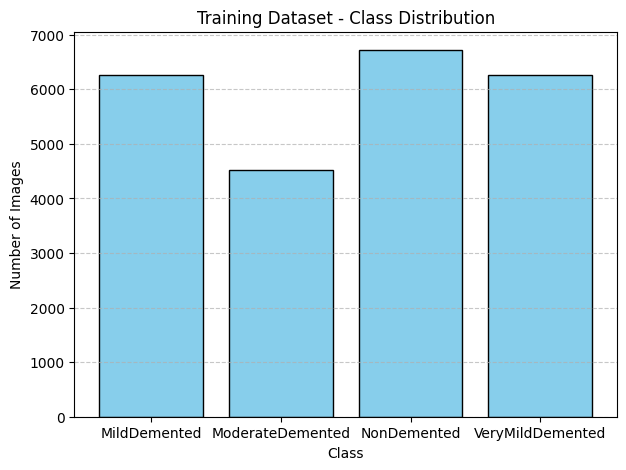

In [12]:
plt.figure(figsize=(7,5))

plt.bar(class_names, counts, color='skyblue', edgecolor='black')
plt.title("Training Dataset - Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


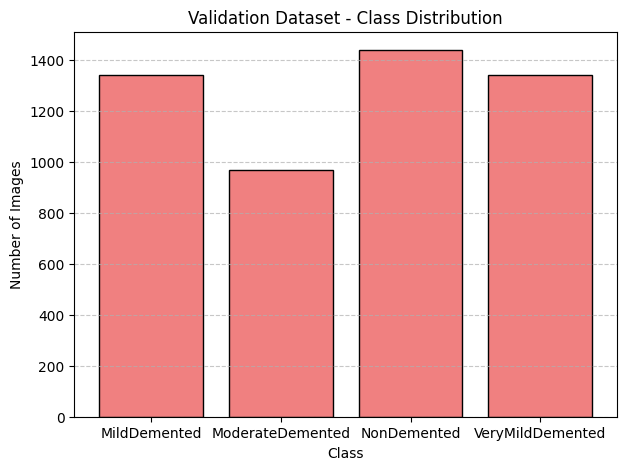

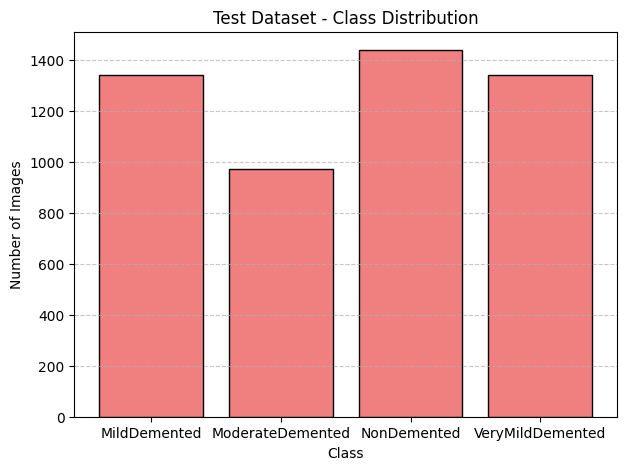

In [13]:
def plot_class_distribution(dataset, title):
    labels = np.concatenate([y for x, y in dataset], axis=0)
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(7,5))
    plt.bar([class_names[i] for i in unique], counts, color='lightcoral', edgecolor='black')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_distribution(val_ds, "Validation Dataset - Class Distribution")
plot_class_distribution(test_ds, "Test Dataset - Class Distribution")


In [4]:
# ======================
# 3. DATA AUGMENTATION
# ======================

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [5]:
# ======================
# 2. SE-ResNet Feature Extractor
# ======================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Multiply()([input_tensor, se])
    return se

def se_resnet50(input_shape=(224, 224, 3)):
    base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base.layers[-20:]:
        layer.trainable = True

    x = base.output
    x = squeeze_excite_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    model = models.Model(inputs=base.input, outputs=x)
    return model

In [6]:
# ======================
# 3. Modified VGG Classifier Head
# ======================
def vgg_classifier_regularized(input_tensor, num_classes):
    x = layers.Dense(4096, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(input_tensor)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(2048, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return output


In [7]:
# ======================
# 4. Combine Model
# ======================
input_shape = (224, 224, 3)
num_classes = len(class_names)

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
se_resnet = se_resnet50(input_shape)
features = se_resnet(x)
outputs = vgg_classifier_regularized(features, num_classes)


model = models.Model(inputs, outputs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:

# ======================
# 5. Compile
# ======================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2048)      │ 24,114,176 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4096)      │  8,392,704 │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2048)      │  8,390,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 4)         │      8,196 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,905,732 (156.04 MB)

 Trainable params: 40,852,612 (155.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
# ======================
# 6. Train
# ======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3),
    ModelCheckpoint('best_realistic_hybrid.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 475s 578ms/step - accuracy: 0.5105 - loss: 1.5325 - val_accuracy: 0.6264 - val_loss: 1.0841 - learning_rate: 3.0000e-04
Epoch 2/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 429s 576ms/step - accuracy: 0.6651 - loss: 1.0139 - val_accuracy: 0.6802 - val_loss: 0.8782 - learning_rate: 3.0000e-04
Epoch 3/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 436s 568ms/step - accuracy: 0.7082 - loss: 0.8248 - val_accuracy: 0.6394 - val_loss: 0.9399 - learning_rate: 3.0000e-04
Epoch 4/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 434s 584ms/step - accuracy: 0.7338 - loss: 0.7020 - val_accuracy: 0.7516 - val_loss: 0.6139 - learning_rate: 3.0000e-04
Epoch 5/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 422s 567ms/step - accuracy: 0.7677 - loss: 0.5919 - val_accuracy: 0.6971 - val_loss: 0.7876 - learning_rate: 3.0000e-04
Epoch 6/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 453s 582ms/step - accuracy: 0.7969 - loss: 0.5259 - val_accuracy: 0.7838 - val_loss: 0.5264 - learning_rate: 3.0000e-04
Epoch 7/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
# ---------- EVALUATION ----------
print("Evaluating on test set...")
results = model.evaluate(test_ds)
print("Test loss, Test accuracy:", results)

Evaluating on test set...
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9635 - loss: 0.1337
Test loss, Test accuracy: [0.22961148619651794, 0.9262600541114807]


In [17]:
#  Unfreeze the last few layers
for layer in model.layers[-20:]:
    layer.trainable = True

#  Recompile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#  Train for few epochs only
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 464s 573ms/step - accuracy: 0.9496 - loss: 0.1554 - val_accuracy: 0.9745 - val_loss: 0.0873
Epoch 2/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 423s 569ms/step - accuracy: 0.9702 - loss: 0.1103 - val_accuracy: 0.9774 - val_loss: 0.0824
Epoch 3/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 443s 570ms/step - accuracy: 0.9756 - loss: 0.0899 - val_accuracy: 0.9831 - val_loss: 0.0691
Epoch 4/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 424s 570ms/step - accuracy: 0.9776 - loss: 0.0855 - val_accuracy: 0.9839 - val_loss: 0.0649
Epoch 5/5
744/744 ━━━━━━━━━━━━━━━━━━━━ 424s 570ms/step - accuracy: 0.9788 - loss: 0.0771 - val_accuracy: 0.9882 - val_loss: 0.0584


In [18]:

# ---------- EVALUATION ----------
print("Evaluating on test set...")
results = model.evaluate(test_ds)
print("Test loss, Test accuracy:", results)

Evaluating on test set...
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9933 - loss: 0.0406
Test loss, Test accuracy: [0.06653709709644318, 0.9837222695350647]


In [38]:
# ======================
# 10. TRAINING & TESTING ACCURACY
# ======================

# 1️⃣ Training Accuracy and Loss
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")
print(f"✅ Training Loss: {train_loss:.4f}")

# 2️⃣ Validation Accuracy and Loss
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"🧪 Validation Accuracy: {val_acc * 100:.2f}%")
print(f"🧪 Validation Loss: {val_loss:.4f}")

# 3️⃣ Test Accuracy and Loss
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"🧾 Test Accuracy: {test_acc * 100:.2f}%")
print(f"🧾 Test Loss: {test_loss:.4f}")


✅ Training Accuracy: 98.99%
✅ Training Loss: 0.0488
🧪 Validation Accuracy: 98.82%
🧪 Validation Loss: 0.0584
🧾 Test Accuracy: 98.37%
🧾 Test Loss: 0.0665


160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      1344
ModerateDemented       1.00      1.00      1.00       971
     NonDemented       0.98      0.97      0.97      1440
VeryMildDemented       0.96      0.98      0.97      1344

        accuracy                           0.98      5099
       macro avg       0.98      0.99      0.99      5099
    weighted avg       0.98      0.98      0.98      5099



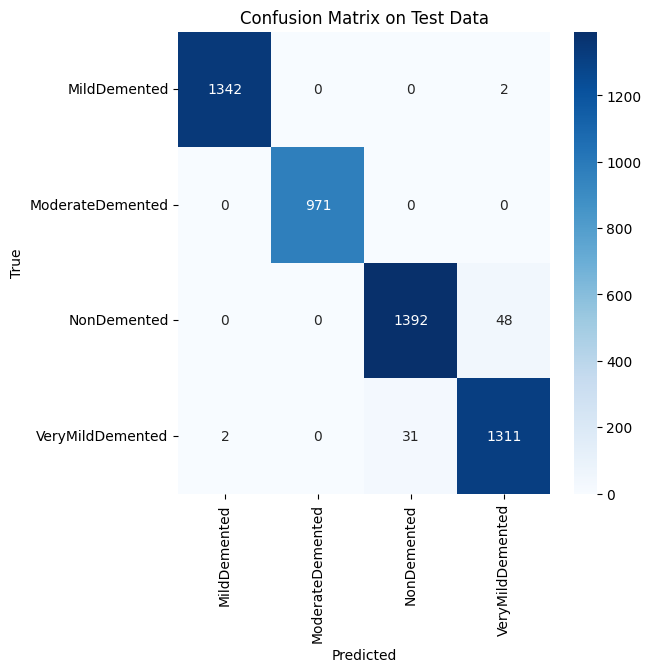

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true & predicted labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data")
plt.show()


In [20]:
model.save("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


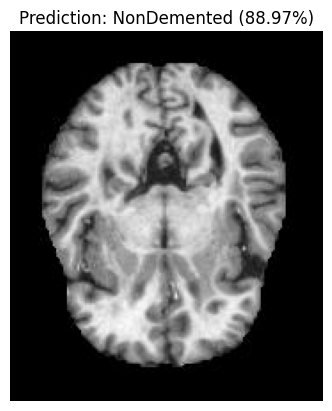

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load saved model
model = tf.keras.models.load_model("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

# Class names (make sure they match your dataset)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Function to test one external image
def test_external_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.show()

# Example: test with any MRI image file path
test_external_image("/content/nonDem0.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


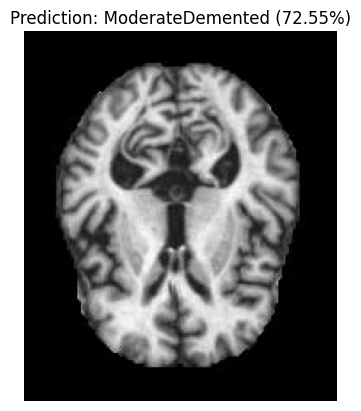

In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load saved model
model = tf.keras.models.load_model("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

# Class names (make sure they match your dataset)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Function to test one external image
def test_external_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.show()

# Example: test with any MRI image file path
test_external_image("/content/moderateDem13.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


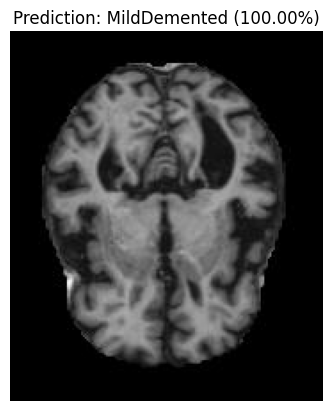

In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load saved model
model = tf.keras.models.load_model("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

# Class names (make sure they match your dataset)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Function to test one external image
def test_external_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.show()

# Example: test with any MRI image file path
test_external_image("/content/mildDem0.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


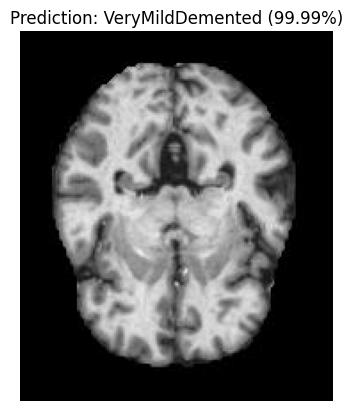

In [27]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load saved model
model = tf.keras.models.load_model("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

# Class names (make sure they match your dataset)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Function to test one external image
def test_external_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.show()

# Example: test with any MRI image file path
test_external_image("/content/verymildDem0.jpg")


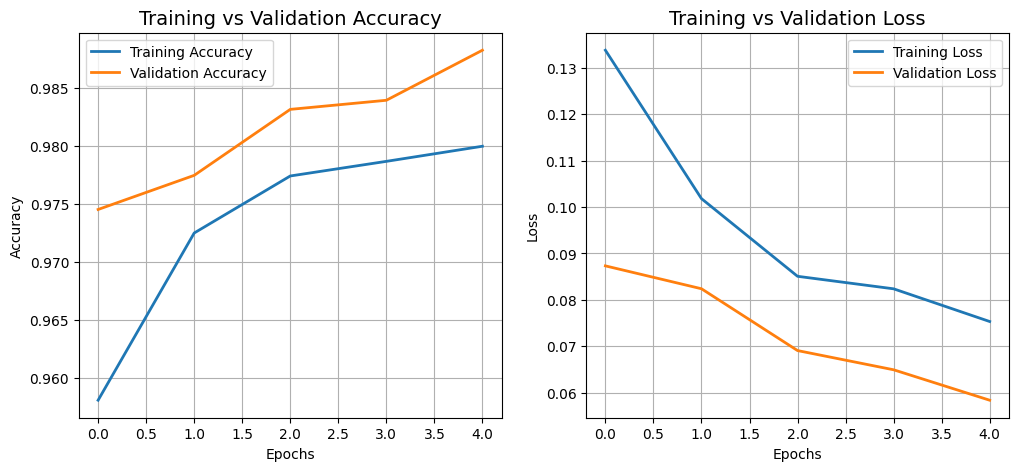

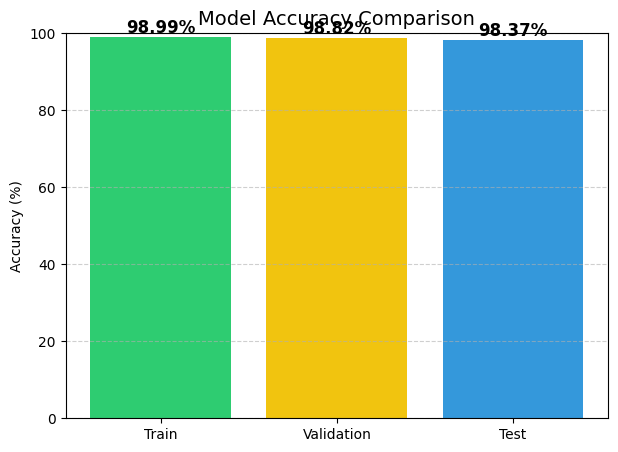

In [39]:
import matplotlib.pyplot as plt

# ======================
# TRAINING HISTORY CURVES
# ======================

plt.figure(figsize=(12, 5))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Training vs Validation Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

# ======================
# FINAL ACCURACY BAR CHART
# ======================

# Evaluate on all datasets again
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

# Accuracy bar chart
plt.figure(figsize=(7, 5))
plt.bar(['Train', 'Validation', 'Test'],
        [train_acc * 100, val_acc * 100, test_acc * 100],
        color=['#2ecc71', '#f1c40f', '#3498db'])
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, acc in enumerate([train_acc, val_acc, test_acc]):
    plt.text(i, acc * 100 + 1, f"{acc * 100:.2f}%", ha='center', fontsize=12, fontweight='bold')

plt.show()
